# Episodic Memory DQN

Paper link : https://arxiv.org/pdf/1805.07603.pdf

The idea is to augment DQN style learning with episodic memory. The episodic memory is a non-parametric method of storing transitions and its associated results. It is stored as a lookup table, and during run-time, it tries to find if the agent has already seen a state close to the current state. If it has, then it returns the associated discounted rewards that the agent had received in the past. This can be used to augment classical learning approaches and can speed up learning. However, since the agent now needs to maintain a second buffer, the memory complexity increases. 

The entire network is trained using a loss function which is a linear combination of two losses - a Q-learning style loss or a TD style loss and a episodic loss. 

In [1]:
from google.colab import drive
drive.mount("/content/drive")
base_path = "/content/drive/My Drive/EMDQN"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import math
import random

import gym
import matplotlib.pyplot as plt

from collections import deque, namedtuple


from sklearn.neighbors import BallTree,KDTree
import os

import gc

import numpy as np
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import random
import cv2
import pickle

In [3]:
#@title Transition
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

In [4]:
#@title SAR
Step = namedtuple('Step', ('state', 'action', 'reward'))

## LRU-KNN

- This component combines the idea of LRU (Least Recently Used) and KNN (K-nearest neighbours). 
- If there is capacity available, then states and the corresponding discounted rewards is inserted into the data structure. 
- If we run out of capacity, then we replace the state that has been "least-recently" used or the oldest state.
- For any given key, we use the KD-tree to get the nearest neighbouring key. If the value is lower than the neigbouring-key value, then the memory is not updated. However, if it is higher, then we replace the value in memory.
- Observation: In case of stochastic rewards, if we continue to get low rewards for most of the time, but get a high reward once, it can throw off the learning process since the max value would be stored in memory. In such settings, it might help to be pessimistic and save the minimum reward (or maybe the average reward) rather than the maximum reward.


In [5]:
# @title LRU-KNN
# https://raw.githubusercontent.com/LinZichuan/emdqn/master/baselines/deepq/experiments/atari/lru_knn.py
# each action -> a lru_knn buffer
class LRU_KNN:
    def __init__(self, capacity, z_dim, env_name):
        self.env_name = env_name
        self.capacity = capacity
        # Map of LRU index to representation of states
        self.states = np.empty((capacity, z_dim), dtype = np.float32)
        self.q_values_decay = np.zeros(capacity)
        # LRU index. Maintain a list of elements by timestamp
        self.lru = np.zeros(capacity)
        self.curr_capacity = 0
        # Timestep. Updated when element is added.
        self.tm = 0.0
        self.tree = None
        self.addnum = 0
        self.buildnum = 256
        self.buildnum_max = 256
        self.bufpath = './buffer/%s'%self.env_name
        self.build_tree_times = 0
        self.build_tree = False

    def load(self, action):
        try:
            assert(os.path.exists(self.bufpath))
            lru = np.load(os.path.join(self.bufpath, 'lru_%d.npy'%action))
            cap = lru.shape[0]
            self.curr_capacity = cap
            self.tm = np.max(lru) + 0.01
            self.buildnum = self.buildnum_max

            self.states[:cap] = np.load(os.path.join(self.bufpath, 'states_%d.npy'%action))
            self.q_values_decay[:cap] = np.load(os.path.join(self.bufpath, 'q_values_decay_%d.npy'%action))
            self.lru[:cap] = lru
            self.tree = KDTree(self.states[:self.curr_capacity])
            print ("load %d-th buffer success, cap=%d" % (action, cap))
        except:
            print ("load %d-th buffer failed" % action)

    def save(self, action):
        if not os.path.exists('buffer'):
            os.makedirs('buffer')
        if not os.path.exists(self.bufpath):
            os.makedirs(self.bufpath)
        np.save(os.path.join(self.bufpath, 'states_%d'%action), self.states[:self.curr_capacity])
        np.save(os.path.join(self.bufpath, 'q_values_decay_%d'%action), self.q_values_decay[:self.curr_capacity])
        np.save(os.path.join(self.bufpath, 'lru_%d'%action), self.lru[:self.curr_capacity])

    def peek(self, key, value_decay, modify):
        # If no entry, then return None
        if self.curr_capacity==0 or self.build_tree == False:
            return None

        # Query the tree for the nearest neighbour to key
        _, idx = self.tree.query([key], k=1)
        idx = idx[0][0]

        # If the values are close to queried key, then return
        # Question : Can we use cosine distance between the two vectors to detect closeness?
        if np.allclose(self.states[idx], key, atol=1e-08):
            self.lru[idx] = self.tm
            self.tm +=0.01
            # If new R_td > old R_td, then update. 
            if modify:
                if value_decay > self.q_values_decay[idx]:
                    self.q_values_decay[idx] = value_decay
            return self.q_values_decay[idx]
        return None

    # If current capacity >= total capacity, then update the oldest index
    # Else add to the last available index
    # Question : Can we optimize this using deque?
    def add(self, key, value_decay):
        if self.curr_capacity >= self.capacity:
            # find the LRU entry
            old_index = np.argmin(self.lru)
            self.states[old_index] = key
            self.q_values_decay[old_index] = value_decay
            self.lru[old_index] = self.tm
        else:
            self.states[self.curr_capacity] = key
            self.q_values_decay[self.curr_capacity] = value_decay
            self.lru[self.curr_capacity] = self.tm
            self.curr_capacity+=1
        self.tm += 0.01


    # Rebuild KD tree using the states
    def update_kdtree(self):
        if self.build_tree:
            del self.tree
        self.tree = KDTree(self.states[:self.curr_capacity])
        self.build_tree = True
        self.build_tree_times += 1
        if self.build_tree_times == 10:
            self.build_tree_times = 0
            gc.collect()

In [6]:
def seed_everything(seed, env):
    np.random.seed(seed)
    random.seed(seed)
    T.manual_seed(seed)
    env.seed(seed)
    # env.action_space.seed(seed)

    if T.cuda.is_available():
        T.backends.cudnn.deterministic = True
        T.backends.cudnn.benchmark = False

In [7]:
# Perform one-hot encoding
def ohe(values, n_values):
    batch_size = len(values)
    ohe_values = np.zeros((batch_size, n_values))
    for idx, value in enumerate(values):
        ohe_values[idx, value] = 1
    return ohe_values

In [8]:
# https://storage.googleapis.com/deepmind-data/assets/papers/DeepMindNature14236Paper.pdf
class DeepQNetwork(nn.Module):
    def __init__(self, lr, img_size, num_actions):
        super(DeepQNetwork, self).__init__()
        self.img_size = img_size
        self.num_actions = num_actions
        self.lr = lr
        self.momentum = 0.9

        # self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size = 3, stride = 1)
        self.conv_net = nn.Sequential(
            nn.Conv2d(4, 32, 8, 4),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, 1),
            nn.ReLU()
        )
        in_features = self.calculate_dim_fc_layer()
        self.action_value = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Linear(256, self.num_actions)
        )
        self.optimizer = optim.RMSprop(self.parameters(), lr=self.lr, momentum=self.momentum)
        self.loss = nn.MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        # self.device = "cpu"
        self.to(self.device)

    def calculate_dim_fc_layer(self):
        state = T.zeros(1, *self.img_size)
        dims = self.conv_net(state)
        return int(np.prod(dims.size()))

    def forward(self, observation):
        observation = T.Tensor(observation).float().to(self.device)  
        observation = F.relu(self.conv_net(observation))
        observation = observation.flatten(start_dim=1)
        actions = self.action_value(observation)
        return actions


In [9]:
class Agent(object):
    def __init__(self, nA, latent_dim=4, img_size=(4, 84, 84), gamma=.999, lr=.003,
                 replay_buffer_size=1_000_000, epsStart=0.95, epsEnd=.05, decayRate=.05,
                 replace=10, alpha = 1, beta = 0.1):

        self.gamma = gamma
        self.epsilon = epsStart
        self.epsStart = epsStart
        self.epsEnd = epsEnd
        self.decayRate = decayRate

        # Co-efficients to weight the losses
        self.alpha = alpha
        self.beta = beta

        self.nA = nA
        self.latent_dim = latent_dim

        self.memory = deque(maxlen = replay_buffer_size)

        self.trajectory = []
        self.learn_counter = 0
        self.replace_target_cnt = replace

        self.Q_eval = DeepQNetwork(lr, img_size, self.nA)
        self.Q_target = DeepQNetwork(lr, img_size, self.nA)
        self.img_size = img_size
        self.random_matrix = np.random.normal(0, 1 / self.latent_dim, size=(self.latent_dim, np.product(self.img_size)))

        self.ec_buffer = [LRU_KNN(5000000, self.latent_dim, 'space_invader') for _ in range(self.nA)]
        self.device = self.Q_eval.device

    def add_to_buffer(self, transition):
        self.memory.append(transition)

    # Manage trajectory
    def add_step_to_trajectory(self, step):
        self.trajectory.append(step)

    def reset_trajectory(self):
        self.trajectory = []

    # Crop image and convert to grayscale
    # https://github.com/PacktPublishing/Deep-Reinforcement-Learning-Hands-On/blob/master/Chapter06/lib/wrappers.py
    def process_state(self, state):
        grayscale_state = self.to_grayscale(state)
        resized_state = self.resize_state(grayscale_state)
        return self.crop_image(resized_state)

    def resize_state(self, state):
        return cv2.resize(state, (84, 110), interpolation=cv2.INTER_AREA)

    def crop_image(self, state):
        return state[18:102, :]

    # https://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_rgb_to_gray.html
    def to_grayscale(self, state):
        weight_vector = [0.2125, 0.7154, 0.0721]
        return np.dot(state, weight_vector)

    # https://github.com/LinZichuan/emdqn/blob/707dc88eb920e8696379183a15bf358c90590519/baselines/common/schedules.py
    # Implements a piecewise schedule scheme common for Atari games.
    def compute_epsilon(self, n):
        endpoints = [(0, 1), (20_000/5, 0.1), (20_000/5, 0.01)]
        for (left, min_lr), (right, max_lr) in zip(endpoints[:-1], endpoints[1:]):
            if n >= left and n <= right:
                alpha = (n-left)/(right-left)
                return min_lr + alpha * (max_lr - min_lr)
        return 0.01

    def update_epsilon(self, n):
        # self.epsilon = self.epsEnd + (self.epsStart - self.epsEnd) * np.exp(-1 * current_episode * self.decayRate)
        self.epsilon = self.compute_epsilon(n)

    # Choose action using epsilon-greedy policy
    def epsilon_greedy(self, observations):
        batch_size = observations.shape[0]
        q_values = self.Q_eval.forward(observations)
        greedy_actions = T.argmax(q_values, 1).cpu().numpy()
        random_actions = np.random.randint(0, self.nA, size=batch_size)
        random_probability = np.random.uniform(0, 1, size=batch_size)
        return np.where(random_probability <  1 - self.epsilon, greedy_actions, random_actions)

    # https://en.wikipedia.org/wiki/Random_projection
    def gaussian_random_projection(self, x):
        return np.dot(self.random_matrix, x)

    # Copy the value of evaluation network into the target network
    def update_target_network(self):
        self.Q_target.load_state_dict(self.Q_eval.state_dict())

    def learn(self, states, actions, rewards, next_states, dones, importance_weights, q_values_for_actions):
        self.Q_eval.optimizer.zero_grad()

        # Converting to list to be given as input to the network
        q_eval = self.Q_eval.forward(list(states)) # current_state prediction using Q_eval network
        q_target = self.Q_target.forward(list(next_states))  # next_state prediction using Q_next network

        # Q values for the actions that were selected
        ohe_actions = T.tensor(ohe(list(actions), self.nA)).to(self.device)
        q_selected = T.sum(q_eval * ohe_actions, dim=1)

        # Choose the highest target Q_value
        Q_target_max = T.max(q_target, dim=1)[0]
        Q_target_max_not_done = T.tensor((1 - np.array(dones))).to(self.device) * Q_target_max
        q_selected_target = T.tensor(rewards).to(self.device) + self.gamma * Q_target_max_not_done

        # Total loss = TD loss + Episodic loss
        td_loss = F.smooth_l1_loss(q_selected, q_selected_target.detach())
        q_episodic_loss = F.smooth_l1_loss(q_selected, q_values_for_actions.detach())

        loss = self.alpha * td_loss + self.beta * q_episodic_loss

        # Weight the loss
        weighted_loss = (T.tensor(importance_weights).to(self.device) * loss).mean()
        T.nn.utils.clip_grad_norm_(self.Q_eval.parameters(),10)

        weighted_loss.backward()

        self.Q_eval.optimizer.step()
        self.learn_counter += 1

    # Take K steps in env. The same action is taken everytime. The states are stacked together and the rewards are added.
    def take_k_steps(self, k, env, action):
        frames = []
        total_reward = 0
        done = False
        for i in range(k):
            next_state, reward, done, info = env.step(action)
            frames.append(self.process_state(next_state))
            total_reward += reward
            # If done, then stop acting.
            if done:
                # If done before kth step, the add the same next step to frames
                frames.extend([self.process_state(next_state) for _ in range(k-(i+1))])
                break
        return frames, total_reward, done, info

    def can_sample_from_memory(self, sample_size):
        return len(self.memory) >= sample_size

    # Sample a batch of experiences from the memory
    def sample_from_memory(self, sample_size):
        sample_transitions = random.sample(self.memory, sample_size)
        return sample_transitions

    # Compute the masked Q-values given observations and actions
    def compute_masked_q_values(self, observations, actions):
        q = self.Q_eval(observations)
        ohe_actions = T.tensor(ohe(list(actions), self.nA)).to(self.device)
        return T.sum(q * ohe_actions, dim=1)

    # Compute discounted rewards and add to episodic_buffer for the chosen action
    def update_episodic_memory(self):
        R_td = 0.
        for step in reversed(self.trajectory):
            state, action, reward = step.state, step.action, step.reward
            R_td = reward + self.gamma * R_td
            z = self.gaussian_random_projection(np.array(state).flatten())
            q_value = self.ec_buffer[action].peek(z, R_td, True)
            if q_value == None:
                self.ec_buffer[action].add(z, R_td)

    # Update KD-tree for all actions
    def update_kdtree(self):
        for a in range(self.nA):
            self.ec_buffer[a].update_kdtree()

    def save(self, path):
        with open(path, 'wb') as f: 
            pickle.dump(self, f, pickle.HIGHEST_PROTOCOL)


# Training loop

- The agent keeps two buffers - the replay buffer and a buffer to store the transitions. 
- The replay buffer is used as in case of classic Q-learning. 
- The transition buffer is used to compute the discounted rewards. Once a trajectory is complete, the agent uses the state-action-reward triplets to compute the discounted rewards, and this is used to update the episodic memory.
- The loss function is a weighted loss function with two components. The first component is similar to the classic Q-learning loss. The second component is an episodic loss where the network tries to bring the predicted Q-value close to the one in episodic memory.
- For the episodic loss, we perform action masking. The Q-network predicts the Q-values for all the actions. However, in the episodic memory, we have values associated only with the actions that the agent actually took. So, we only take the predicted Q-values of the actions that the agent took for the purposes of the episodic loss, and compare that with the Q-values from the episodic memory.
- The episodic memory is used as a secondary buffer to augment the Q-learning process.

In [ ]:
env = gym.make('SpaceInvaders-v0')
seed_everything(42, env)
nA = env.action_space.n
scores = []
n_episodes = 10
batch_size = 32
trajectories = []
qecwatch = []
done = False
n_steps = 0
target_update_frequency = 4000
total_reward = 0
# number of frames to stack
k = 4
performance = {}

episode_complete = False

# Initialize agent
agent = Agent(nA)
agent.update_target_network()

# Stack the same frame k times for the initial state
state = env.reset()
observation = [agent.process_state(state) for _ in range(k)]

# Training Loop
while True:
    n_steps += 1
    # Shape of observation : [1, k, 84, 84]
    action = agent.epsilon_greedy(np.array(observation)[None])[0]

    # Take the same action k times
    next_observation, reward, done, info = agent.take_k_steps(k, env, action)

    total_reward += reward

    # Store observations, action and clipped reward
    agent.add_step_to_trajectory(Step(observation, action, np.clip(reward, -1, 1)))

    # Store transition in replay buffer
    agent.add_to_buffer(Transition(observation, action, next_observation, reward, float(done)))
    agent.update_epsilon(n_steps)
    observation = next_observation

    # If episode has terminated, then update episodic memory using TD rewards
    # And reset the trajectory and environment
    if done:
        agent.update_episodic_memory()
        agent.reset_trajectory()
    
        scores.append(total_reward)
        n_episodes = len(scores)
        performance[n_episodes] = np.mean(scores[-30:])
        print(f'Episode : {n_episodes}, Steps so far: {n_steps}, Rewards : {total_reward}, Rewards (last 10 average) : {np.mean(scores[-30:])}')

        total_reward = 0
        episode_complete = True

        # Run for 100_000 steps
        if n_steps == 20_000:
            break

        state = env.reset()
        observation = [agent.process_state(state) for _ in range(k)]

    # Sample only when memory has atleast batch_size elements
    if agent.can_sample_from_memory(batch_size):
        sample_transitions = agent.sample_from_memory(batch_size)
        weights = np.ones(batch_size)

        # Compute q_values for actions
        transitions_ = Transition(*zip(*sample_transitions))
        observations, actions, rewards, next_observations, dones = transitions_.state, transitions_.action, transitions_.reward, transitions_.next_state, transitions_.done
        q_values_for_actions = agent.compute_masked_q_values(observations, actions)

        # For the states and actions, if an entry is present in the episodic memory, then use that
        for i in range(batch_size):
            z = agent.gaussian_random_projection(np.array(observations[i]).flatten())
            q_ = agent.ec_buffer[actions[i]].peek(z, None, modify=False)
            if q_ is not None:
                q_values_for_actions[i] = q_

        agent.learn(observations, actions, rewards, next_observations, dones, weights, q_values_for_actions)

        if n_steps % target_update_frequency == 0:
            agent.update_target_network()
            agent.update_kdtree()
            agent.save(f"{base_path}/agent.pkl")

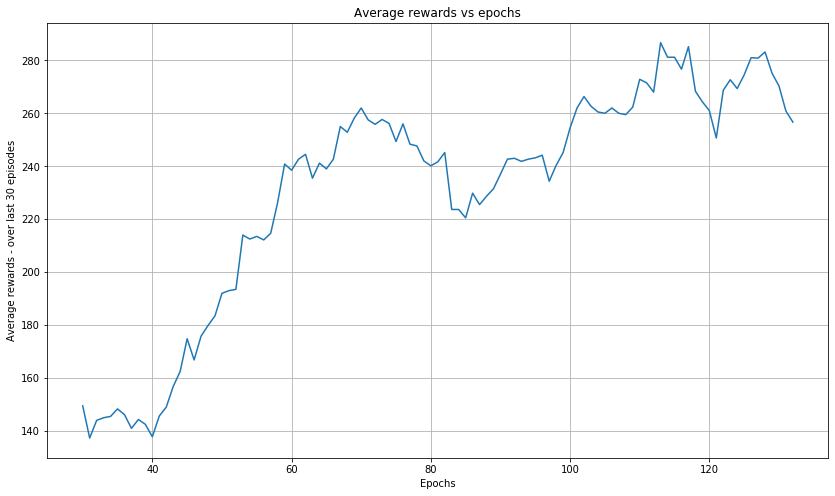

In [18]:
# Plotting rewards average vs number of epochs
plt.figure(figsize=(14,8))
plt.xlabel("Epochs")
plt.ylabel("Average rewards - over last 30 episodes")
plt.title("Average rewards vs epochs")
plt.ticklabel_format(axis = 'both', style='plain')
plt.grid()
plt.plot(list(performance.keys()), list(performance.values()))

## Observations
- There is a relative weighting scheme used by the loss function. The authors define two weights - alpha and beta, which are used to give importance to different aspects of the loss function. In the paper, the authors fix the value of alpha = 1 and beta = 0.1. They define lambda = beta/alpha and claim that a large value of lambda can be detrimental to learning.
- The values of alpha and beta should depend on the choice of environment. A dynamic gating scheme that gives importance to episodic memory early in training can be useful for environments with deterministic rewards, but might prove to be detrimental for stochastic rewards.
- Although they say it is Q-learning, they use a TD-style update. I think the main idea is whatever be the learning style, it can be augmented with episodic learning
- In Atari style experiements, the learning rate is updated using a Piecewise Schedule, which is dependent on the number of steps to the taken. In most papers, this is set to 40M steps. For the purposes of our experiment, we have set it to 20,000 steps.
- One of the arguments for using episodic memory is that it reduces the sample complexity. While this is true, as pointed out earlier, these agents need a secondary buffer and hence will have higher memory complexity. 